# Ladder Sampling of 2D Ising Model

## Hamiltonian
\begin{align}
H = -\sum_{<ij>}J_{ij}S_{i} S_{j} - \sum_{i}^{N} h_{i}S_{i},
\end{align}
where $N$ is the number of spins and we assume $J_{ij} = J$.

----

### Ladder Sampling of 2D Ising model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import time

In [2]:
class ISING_2D_ladder:
    
    def __init__(self, j=1, beta=1, h=1, dims=(10, 10)):
        """
        Args:
            nc: (int) size of the cluster.
        """
        self.j = j
        self.beta = beta
        self.h = h
        self.dims = dims
        self.grids = (-1) ** np.reshape(np.random.binomial(1, 1/2, dims[0]*dims[1]), dims)
        self.dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        
    def neibor_get(self, id_grid):
        height, width = self.dims
        height_index, width_index = id_grid
        l_neibor = (height_index, (width_index - 1) % width)
        r_neibor = (height_index, (width_index + 1) % width)
        u_neibor = ((height_index - 1) % height, width_index)
        d_neibor = ((height_index + 1) % height, width_index)          
        ur_neibor = ((height_index - 1) % height, (width_index + 1) % width)
        dl_neibor = ((height_index + 1) % height, (width_index - 1) % width)
        
        return {'l': l_neibor, 
                'r': r_neibor, 
                'u': u_neibor, 
                'd': d_neibor, 
                'ur': ur_neibor, 
                'dl': dl_neibor}
    
    def message_on_node(self, id_ud, neibors_ud):
        def energy_get(spins_ud, neibors_ud):
            energy = 0
            spin_u, spin_d = spins_ud
            neibors_u, neibors_d = neibors_ud
            for id_neibor in neibors_u:
                energy += -self.j * spin_u * self.grids[id_neibor[0]][id_neibor[1]]
            for id_neibor in neibors_d:
                energy += -self.j * spin_d * self.grids[id_neibor[0]][id_neibor[1]]
            return energy
        spins_list = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        energy_uu = energy_get((1, 1), neibors_ud)
        energy_ud = energy_get((1, -1), neibors_ud)
        energy_du = energy_get((-1, 1), neibors_ud)
        energy_dd = energy_get((-1, -1), neibors_ud)
        message = np.array([np.exp(-self.beta * energy_uu), 
                            np.exp(-self.beta * energy_ud),
                            np.exp(-self.beta * energy_du), 
                            np.exp(-self.beta * energy_dd)])
        return message         
            
    def message_on_pair_nodes(self, id_ud, neibors_ud):
        def energy_get(spins_ud, neibors_ud):
            energy = 0
            spin_u, spin_d = spins_ud
            neibors_u, neibors_d = neibors_ud
            for id_neibor in neibors_u:
                energy += -self.j * spin_u * self.grids[id_neibor[0]][id_neibor[1]]
            energy += -self.j * self.h * spin_u
            for id_neibor in neibors_d:
                energy += -self.j * spin_d * self.grids[id_neibor[0]][id_neibor[1]]
            energy += -self.j * self.h * spin_d
            energy += -self.j * self.h * spin_u
            energy += -self.j * spin_u * spin_d
            return energy
        energy_uu = energy_get((1, 1), neibors_ud)
        energy_ud = energy_get((1, -1), neibors_ud)
        energy_du = energy_get((-1, 1), neibors_ud)
        energy_dd = energy_get((-1, -1), neibors_ud)
        message = np.array([np.exp(-self.beta * energy_uu), np.exp(-self.beta * energy_ud),
                            np.exp(-self.beta * energy_du), np.exp(-self.beta * energy_dd)])
        #message = np.array([np.exp(-self.beta * (-energy_dd)), 
        #                    np.exp(-self.beta * (energy_ud - energy_uu - energy_dd)),
        #                    np.exp(-self.beta * (energy_du - energy_uu - energy_dd)), 
        #                    np.exp(-self.beta * (-energy_uu))])
        
        #message_norm = message / np.sum(message)
        #return message_norm
        return message
    
    def message_on_edge(self):
        """
        Args:
            edge: (tuple) (node_start, node_end)
            
        Returns:
            message: (np.array) 4x4 matrix
        """
        def message_compute_one_row(spins_left, spins_right_list):
            """
            Args:
                spins_left: (tuple)
                spins_right_list: (list) 
                
            Returns:
                left_right_row: (np.array)
            """
            spin_lu, spin_ld = spins_left
            left_right_list = []
            for spins_right in spins_right_list:
                energy_total = 0
                spin_ru, spin_rd = spins_right
                energy_total += -self.j * spin_lu * spin_ru
                energy_total += -self.j * spin_ld * spin_rd
                energy_total += -self.j * spin_ld * spin_ru
                left_right_list.append(np.exp(-self.beta * energy_total))
            return np.array(left_right_list)
        
        spins_left_list = spins_right_list = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
        message_list = []
        for spins_left in spins_left_list:
            message_list.append(message_compute_one_row(spins_left, spins_right_list))
        message = np.array(message_list)
        #message = message / (message[0][0] * message[-1][-1])
        return message    
    
    def loop_sampling(self, id_height):
        id_end = np.random.randint(self.dims[1])
        id_start = (id_end + 1) % self.dims[1]
        path_to_left = [id_start, id_end] 
        path_to_right = [(id_start + i) % self.dims[1] for i in range(self.dims[1])]
        assert path_to_right[-1] == id_end, "Path to right is not right!"
        ### get the message on the edge which is shared by all the other edge
        message_edge = self.message_on_edge()
        message_edge_transpose = np.transpose(message_edge)
        message_on_node = []
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        for id_width in range(self.dims[1]):
            id_u, id_d = ((id_height + 1) % self.dims[0], id_width), (id_height, id_width)
            id_ud = (id_u, id_d)
            neibors_u = self.neibor_get(id_u)
            neibors_d = self.neibor_get(id_d)
            keys_u = ('u', 'ur')
            keys_d = ('d', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
            neibors_ud = (neibors_u, neibors_d)
            message_node = self.message_on_pair_nodes(id_ud, neibors_ud)
            message_on_node.append(message_node)
        z_right = np.sqrt(message_on_node[id_start])
        z_left = np.sqrt(message_on_node[id_start])
        id_start_right = id_start
        while id_start_right != id_end:
            id_start_right = (id_start_right + 1) % self.dims[1]
            z_right = np.matmul(z_right, message_edge)
            if id_start_right == id_end:
                z_right *= np.sqrt(message_on_node[id_start_right])
            else:
                z_right *= message_on_node[id_start_right]
        id_start_left = id_start
        while id_start_left != id_end:
            id_start_left = (id_start_left - 1) % self.dims[1]
            z_left = np.matmul(z_left, message_edge_transpose)
            if id_start_left == id_end:
                z_left *= np.sqrt(message_on_node[id_start_left])
            else:
                z_left *= message_on_node[id_start_left]      
        z = z_left * z_right
        z_norm = z / np.sum(z)
        unif_random = np.random.uniform(0, 1)
        if unif_random < z_norm[0]:
            spin_start = np.array([1, 1])
        elif z_norm[0] <= unif_random < z_norm[0] + z_norm[1]:
            spin_start = np.array([1, -1])
        elif z_norm[0] + z_norm[1] <= unif_random < 1 - z_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        self.grids[id_height][id_end] = spin_start[0]
        self.grids[(id_height+1)%self.dims[0]][id_end] = spin_start[1]
        return id_end
    
    def chain_sampling(self, id_height, id_start):
        stack = []
        id_end = (id_start - 1) % self.dims[1]
        id_start = (id_start + 1) % self.dims[1]
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        if self.dims[1] > 2:
            start_d = ((id_height + 1) % self.dims[0], id_start)
            start_u = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl')
            keys_d = ('l', 'd', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        else:
            start_u = ((id_height + 1) % self.dims[0], id_start)
            start_d = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl', 'r')
            keys_d = ('ur', 'l', 'd', 'dl', 'r')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        message_edge = self.message_on_edge()
        start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
        z_start = self.message_on_pair_nodes(start_ud, neibors_ud)
        stack.append(z_start)
        while id_start != id_end:
            id_start = (id_start + 1) % self.dims[1]
            z_start = np.matmul(z_start, message_edge)
            if id_start == id_end:
                start_d = ((id_height + 1) % self.dims[0], id_start)
                start_u = (id_height % self.dims[0], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur', 'r')
                keys_d = ('d', 'dl', 'r', 'ur')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            else:
                start_d = ((id_height + 1) % self.dims[0], id_start)
                start_u = (id_height % self.dims[0], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur')
                keys_d = ('d', 'dl')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
            node_message = self.message_on_pair_nodes(start_ud, neibors_ud)
            z_start = z_start * node_message
            stack.append(z_start)
        z_start = stack.pop()
        z_start_norm = z_start / np.sum(z_start)
        unif_random = np.random.uniform(0, 1)
        if unif_random < z_start_norm[0]:
            spin_start = np.array([1, 1])
        elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
            spin_start = np.array([1, -1])
        elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        self.grids[id_height][id_start] = spin_start[0]
        self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
        
        return stack, id_start
    
    def _chain_sampling_test(self, id_height, id_start):
        stack = []
        id_end = (id_start - 1) % self.dims[1]
        id_start = (id_start + 1) % self.dims[1]
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        if self.dims[1] > 2:
            start_u = ((id_height + 1) % self.dims[0], id_start)
            start_d = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl')
            keys_d = ('l', 'd', 'dl')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        else:
            start_u = ((id_height + 1) % self.dims[0], id_start)
            start_d = (id_height % self.dims[0], id_start)
            neibors_u = self.neibor_get(start_u)
            neibors_d = self.neibor_get(start_d)
            keys_u = ('u', 'ur', 'l', 'dl', 'r')
            keys_d = ('ur', 'l', 'd', 'dl', 'r')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
        message_edge = self.message_on_edge()
        start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
        z_start = self.message_on_pair_nodes(start_ud, neibors_ud)
        stack.append(z_start)
        while id_start != id_end:
            id_start = (id_start + 1) % self.dims[1]
            z_start = np.matmul(z_start, message_edge)
            if id_start == id_end:
                start_u = ((id_height + 1) % self.dims[0], id_start)
                start_d = (id_height % self.dims[0], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur', 'r')
                keys_d = ('d', 'dl', 'r', 'ur')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            else:
                start_u = ((id_height + 1) % self.dims[0], id_start)
                start_d = (id_height % self.dims[0], id_start)
                neibors_u = self.neibor_get(start_u)
                neibors_d = self.neibor_get(start_d)
                keys_u = ('u', 'ur')
                keys_d = ('d', 'dl')
                neibors_u = dict_filter(neibors_u, keys_u)
                neibors_d = dict_filter(neibors_d, keys_d)
            start_ud, neibors_ud = (start_u, start_d), (neibors_u, neibors_d)
            node_message = self.message_on_pair_nodes(start_ud, neibors_ud)
            z_start = z_start * node_message
            stack.append(z_start)
        z_start = stack.pop()
        z = np.sum(z_start)
        z_start_norm = z_start / z
        unif_random = np.random.uniform(0, 1)
        if unif_random < z_start_norm[0]:
            spin_start = np.array([1, 1])
        elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
            spin_start = np.array([1, -1])
        elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
            spin_start = np.array([-1, 1])
        else:
            spin_start = np.array([-1, -1])
        self.grids[id_height][id_start] = spin_start[0]
        self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
        
        return stack, id_start, z_start, z
    
    def backtrack_sampling(self, id_height, id_start, stack):
        spins_list = []
        message_edge = self.message_on_edge()
        dict_filter = lambda old_dict, keys_set: [old_dict[key] for key in keys_set]
        while len(stack) != 0:
            id_start = (id_start - 1) % self.dims[1]   
            start_u = (id_height, id_start)
            start_d = ((id_height + 1) % self.dims[0], id_start)
            neibors_d = self.neibor_get(start_d)
            neibors_u = self.neibor_get(start_u)
            #keys_u = ('u', 'ur', 'r')
            #keys_d = ('ur', 'r', 'd', 'dl')
            keys_u = ('r')
            keys_d = ('r', 'ur')
            neibors_u = dict_filter(neibors_u, keys_u)
            neibors_d = dict_filter(neibors_d, keys_d)
            start_ud = (start_u, start_d)
            neibors_ud = (neibors_u, neibors_d)
            message_node = self.message_on_node(start_ud, neibors_ud)
            #message_node = self.message_on_pair_nodes(start_ud, neibors_ud)
            z_start = message_node * stack.pop()
            z_start_norm = z_start / np.sum(z_start)
            unif_random = np.random.uniform(0, 1)
            if unif_random < z_start_norm[0]:
                spin_start = np.array([1, 1])
            elif z_start_norm[0] <= unif_random < z_start_norm[0] + z_start_norm[1]:
                spin_start = np.array([1, -1])
            elif z_start_norm[0] + z_start_norm[1] <= unif_random < 1 - z_start_norm[-1]:
                spin_start = np.array([-1, 1])
            else:
                spin_start = np.array([-1, -1])
            self.grids[id_height][id_start] = spin_start[0]
            self.grids[(id_height+1)%self.dims[0]][id_start] = spin_start[1]
    
    def ladder_sampling(self, id_height, id_start):
        #id_start = self.loop_sampling(id_height)
        stack, id_start = self.chain_sampling(id_height, id_start)
        self.backtrack_sampling(id_height, id_start, stack)
        
    def ladder_evolution(self):
        for id_start in [0, -1]:
            for i in range(self.dims[0]):
                self.ladder_sampling(i, id_start)
        #self.grids = np.transpose(self.grids)
        #for i in range(self.dims[1]):
        #    self.ladder_sampling(i)
        #self.grids = np.transpose(self.grids)
        
    def _exact_sampling(self, id_height, id_start):       
        def energy_compute(id_width, grids):
            energy_site = 0
            id_spin = grids[id_height][id_width]
            id_site = (id_height, id_width)
            id_neibors_orig = self.neibor_get(id_site)
            keys_neibors = ('u', 'd', 'ur', 'dl')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += -self.j * grids[neibor[0]][neibor[1]] * id_spin
            keys_neibors = ('l', 'r')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += -1/2 * self.j * grids[neibor[0]][neibor[1]] * id_spin
            energy_site += -self.h * id_spin
            return energy_site
        
        def z_site_compute(grids):
            energy_full = 0
            for id_width in range(self.dims[1]):
                energy_full += energy_compute(id_width, grids)
            z_part = np.exp(-self.beta * energy_full)
            return z_part, energy_full
        
        def energy_compute_double(id_height, id_width, grids):
            energy_site = 0
            id_spin = grids[id_height][id_width]
            id_site = (id_height, id_width)
            id_neibors_orig = self.neibor_get(id_site)
            keys_neibors = ('u', 'd', 'ur', 'dl')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += -self.j * grids[neibor[0]][neibor[1]] * id_spin
            keys_neibors = ('l', 'r')
            id_neibors = self.dict_filter(id_neibors_orig, keys_neibors)
            for neibor in id_neibors:
                energy_site += -1/2 * self.j * grids[neibor[0]][neibor[1]] * id_spin
            energy_site += -self.h * id_spin
            return energy_site            
        
        def z_site_compute_double(grids):
            energy_full = 0
            for w in range(id_start+1, self.dims[1]):
                energy_full += energy_compute_double(id_height, w, grids)
                energy_full += energy_compute_double((id_height+1)%self.dims[0], w, grids)
            z_part = np.exp(-self.beta * energy_full)
            return z_part, energy_full
        
        def z_part_compute(id_start, spin_start, grids):
            num_site = 2 ** (self.dims[1] - 1)
            z_part_start = 0
            energy_list = []
            for i in range(num_site):
                site_i = list('0' * self.dims[1] + bin(i)[2:])[1-self.dims[1]:]
                site_i.insert(id_start, spin_start)
                site_i = np.array(site_i, dtype=np.int32)
                site_i = (-1) ** site_i
                grids[id_height] = site_i
                print(grids)
                z_i, energy_i = z_site_compute(grids)
                z_part_start += z_i
                energy_list.append(energy_i)
            return z_part_start, energy_list
        
        def spin_array_create(i, id_start, id_spin):
            """
            Args:
                i: (int) 
                id_start: (int)
                id_spin: (int) 0 or 1
            """
            site_i = list('0' * self.dims[1] + bin(i)[2:])[1-self.dims[1]:]
            site_i.insert(id_start, id_spin)
            site_i = np.array(site_i, dtype=np.int32)
            site_i = (-1) ** site_i
            
            return site_i
        
        def z_part_compute_double(id_start, ud_start, grids):
            num_site = 2 ** (self.dims[1] - 1)
            z_part_start = 0
            energy_list = []
            u_start, d_start = ud_start
            for i in range(num_site):
                for j in range(num_site):
                    site_i = spin_array_create(i, id_start, u_start)
                    site_j = spin_array_create(j, id_start, d_start)
                    print(site_i)
                    print(site_j)
                    grids[id_height] = site_i
                    grids[(id_height+1)%self.dims[0]] = site_j
                    z_i, energy_i = z_site_compute_double(grids)
                    z_part_start += z_i
                    energy_list.append(energy_i)
            return z_part_start, energy_list
                    
        spin_u = (self.grids[id_height][id_start] + 1) / 2
        spin_d = (self.grids[(id_height+1)%self.dims[0]][id_start] + 1) / 2
        ud_start = (spin_u, spin_d)
        grids = self.grids.copy()
        z_part, energy_list = z_part_compute_double(id_start, ud_start, grids)
        return z_part, energy_list
                     
    def tree_create(self):
        def neibor_search(id_grid, tree_list):
            height, width = id_grid
            neibors = []
            num_shared = 0
            if height < self.dims[0] - 1:
                if (height + 1, width) not in tree_list:
                    neibors.append((height + 1, width))
                else:
                    num_shared += 1
            if height > 0:
                if (height - 1, width) not in tree_list:
                    neibors.append((height - 1, width))
                else:
                    num_shared += 1
            if width < self.dims[1] - 1:
                if (height, width + 1) not in tree_list:
                    neibors.append((height, width + 1))
                else:
                    num_shared += 1
            if width > 0:
                if (height, width - 1) not in tree_list:
                    neibors.append((height, width - 1))
                else:
                    num_shared += 1
                    
            return neibors, num_shared
        
        tree_list = []
        stack = []
        height, width = self.dims
        height_rand = np.random.randint(0, height)
        width_rand = np.random.randint(0, width)
        id_start = (height_rand, width_rand)
        stack.append(id_start)
        while len(tree_list) < self.nc:
            node_leaf = stack.pop()
            if node_leaf in tree_list:
                tree_list.pop()
                continue
            neibors_leaf, num_shared = neibor_search(node_leaf, tree_list)
            if len(neibors_leaf) >= 1 and num_shared < 2:
                tree_list.append(node_leaf)
                stack.append(node_leaf)
                stack.extend(neibors_leaf)
            else:
                if node_leaf == tree_list[-1]:
                    tree_list.pop()
        return tree_list
    
    def tree_viz(self):
        zero_one_row = 'o' * self.dims[1] + '\n'
        zeros_grids = zero_one_row * self.dims[0]
        for node in self.tree_list:
            node_pos = node[0] * (self.dims[1] + 1) + node[1]
            zeros_grids = zeros_grids[:node_pos] + 'x' + zeros_grids[node_pos+1:]
        print(zeros_grids)
        
    def spin_viz(self, figsize=(10, 10), save=False, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.dims[0]), np.arange(0, self.dims[1]))
        u = np.cos(self.grids*np.pi/2)
        v = np.sin(self.grids*np.pi/2)
        q = plt.quiver(x, y, u, v)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.dims), fontsize=20)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
            plt.close(fig)
            
    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.dims[0]):
            for j in range(self.dims[1]):
                id_neibors_dict = self.neibor_get((i, j))
                id_neibors = id_neibors_dict.values()                
                energy_ij = 0
                for ij in id_neibors:
                    energy_ij = -1/2 * self.j * self.grids[ij[0]][ij[1]] * self.grids[i][j]
                    energy_total += energy_ij
                ### compute the energy of external field
                energy_total += -self.h * self.grids[i][j]
        energy_per_spin = energy_total / (self.dims[0] * self.dims[1])
        return energy_per_spin
    
    def magnet_grids(self):
        magnet_x, magnet_y = 0, 0
        for i in range(self.length):
            magnet_x += np.sin(self.grids[i])
            magnet_y += np.cos(self.grids[i])
        return magnet_x, magnet_y

### Low Temperature (External Field h = 0)

In [160]:
ising_2d = ISING_2D_ladder(beta=10, j=1, h=0, dims=(5, 5))

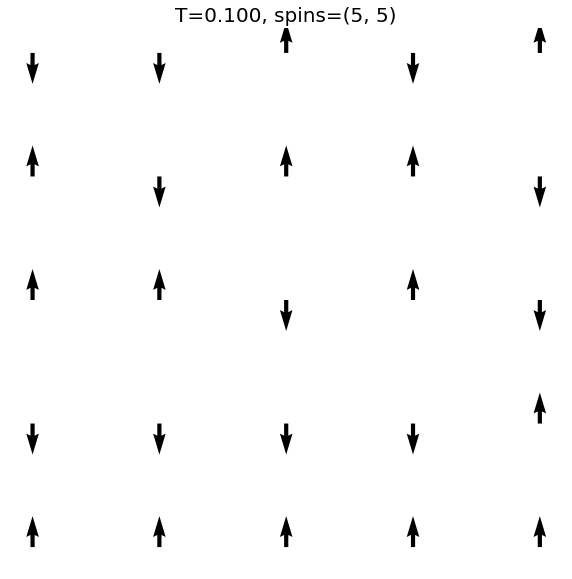

In [161]:
ising_2d.spin_viz()

In [162]:
ising_2d.ladder_evolution()

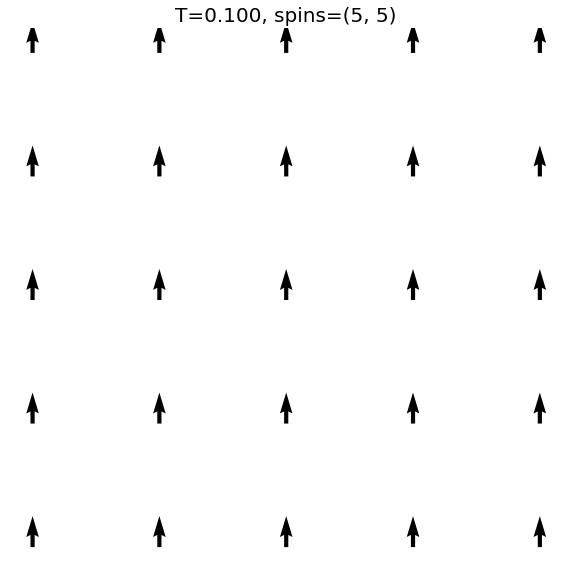

In [163]:
ising_2d.spin_viz()

In [164]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -3.000.


------
### High Temperature (External Field = 0)

In [165]:
ising_2d = ISING_2D_ladder(beta=1, j=1, h=0, dims=(10, 10))

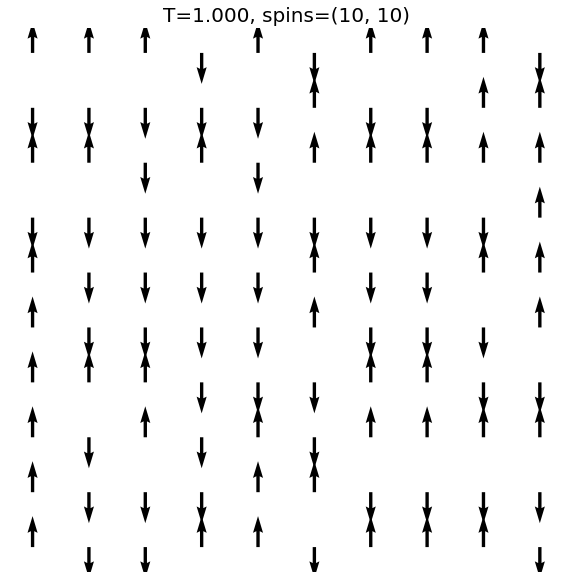

In [166]:
ising_2d.spin_viz()

In [167]:
ising_2d.ladder_evolution()

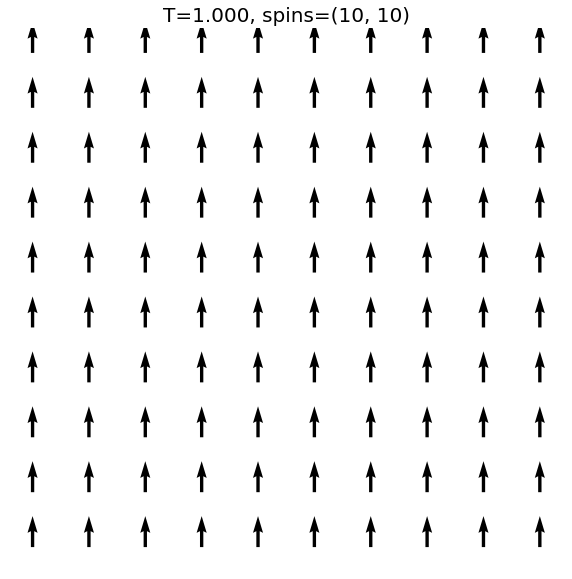

In [168]:
ising_2d.spin_viz()

In [169]:
print(f"The energy of the system is: {ising_2d.energy_compute_grids():.3f}.")

The energy of the system is: -3.000.


-----
### J > 0

In [152]:
beta_list = [0.05 * i for i in range(1, 11)]
temp_list = [1 / beta for beta in beta_list]
dims = (5, 5)

In [153]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(10):
    beta = beta_list[i]
    ising_2d = ISING_2D_ladder(beta=beta, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.ladder_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.ladder_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [156]:
mean_sampling_list

[-0.167936,
 -0.380272,
 -0.671568,
 -1.152736,
 -1.875664,
 -2.477488,
 -2.75408,
 -2.87696,
 -2.937392,
 -2.96784]

In [155]:
std_sampling_list

[0.3853257062590037,
 0.4385560922117033,
 0.5435532921213889,
 0.7000715637018833,
 0.7759548950190339,
 0.5716883852729562,
 0.3778111612962221,
 0.26071846578253716,
 0.1822303990447258,
 0.12777971043949032]

In [157]:
energy_metropolis_list = [-0.164896,
                          -0.3740704,
                          -0.6458208,
                          -1.1592592,
                          -1.8570512,
                          -2.450304,
                          -2.7503168000000007,
                          -2.8719392,
                          -2.9364928000000003,
                          -2.9658368000000004]

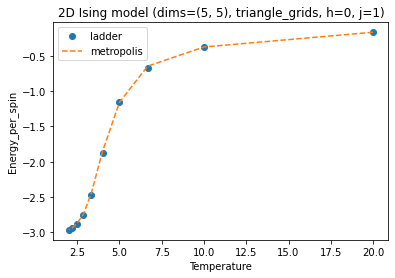

In [159]:
plt.plot(temp_list, mean_sampling_list, 'o', label='ladder')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5), triangle_grids, h=0, j=1)')
plt.legend()

----------
### J < 0

In [3]:
beta_list = [0.02 * i for i in range(1, 21)]
temp_list = [1 / beta for beta in beta_list]
dims, j = (5, 5), -1

In [4]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(20):
    beta = beta_list[i]
    ising_2d = ISING_2D_ladder(beta=beta, j=j, h=0, dims=dims)
    ### Get to the equilibrium state
    for _ in trange(10000):
        ising_2d.ladder_evolution()
    ### Sampling stage
    energy_list = []
    for i in trange(10000):
        ising_2d.ladder_evolution()
        energy_list.append(ising_2d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [5]:
mean_sampling_list

[-0.057328,
 -0.111408,
 -0.165216,
 -0.20220800000000003,
 -0.25151999999999997,
 -0.290784,
 -0.324592,
 -0.36337600000000003,
 -0.390032,
 -0.42904000000000003,
 -0.454112,
 -0.483808,
 -0.5097119999999999,
 -0.5406719999999999,
 -0.5612959999999999,
 -0.581584,
 -0.5997599999999998,
 -0.6233279999999999,
 -0.6419039999999999,
 -0.6596479999999999]

In [6]:
std_sampling_list

[0.3346552560710798,
 0.320723833751095,
 0.30825391050885304,
 0.3005705320486358,
 0.28645434121339475,
 0.277795077969355,
 0.2696902548035431,
 0.2578857937615021,
 0.2543481059021278,
 0.24734922356862168,
 0.24027827920142927,
 0.23317405330782412,
 0.22595521028734877,
 0.21757101924658992,
 0.21160472675249956,
 0.20959096102647173,
 0.2023223724653307,
 0.1939858871567723,
 0.19277233926058998,
 0.1850488478645571]

In [7]:
energy_metropolis_list = [-0.0593264,
                          -0.1117728,
                          -0.15559360000000003,
                          -0.2061952,
                          -0.24400640000000004,
                          -0.2867968,
                          -0.32193440000000006,
                          -0.3552624,
                          -0.39665120000000004,
                          -0.42617279999999996,
                          -0.4607104,
                          -0.4826992,
                          -0.49970399999999987,
                          -0.5395984,
                          -0.5640528,
                          -0.5806271999999999,
                          -0.6022255999999999,
                          -0.6232991999999998,
                          -0.6436031999999999,
                          -0.6594736]

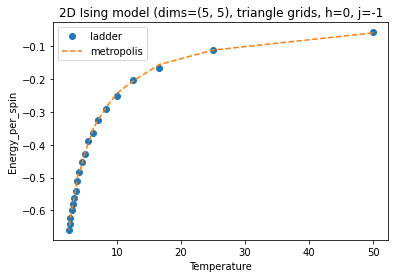

In [8]:
plt.plot(temp_list, mean_sampling_list, 'o', label='ladder')
plt.plot(temp_list, energy_metropolis_list, '--', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('2D Ising model (dims=(5, 5), triangle grids, h=0, j=-1')
plt.legend()